# Residual W-Net Training

This notebook trains a residual W-Net model for enhanced JPEG reconstruction.

Details:
- On the fly data augmentation
- JPEG quality varying between 10-20
- Dropout

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.backend import eval as tf_eval

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from cs_models import deep_cascade_unet_no_dc

Using TensorFlow backend.


In [2]:
# Train and validation data paths
images_path = "../../Gray/*.tif"
images = glob.glob(images_path)
print(len(images))
# Listing train and validation images
train_images = images[0:30000]
val_images = images[30000:45000]
test_images = images[45000:]

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))
print("Test set size:",len(test_images))

48624
Train set size: 30000
Validation set size: 15000
Test set size: 3624


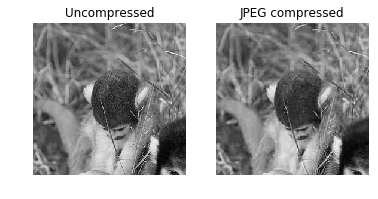

In [3]:
# Load uncompressed image
im1 = Image.open(train_images[200])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [5]:
H,W = 256, 256
norm = 255.0
compr_range = (15,16)

compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(train_images),replace = True)

# Train set
train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1,dtype=np.float32)

    
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

# Validation set
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_compr = val_unc.copy()

for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1,dtype=np.float32)

    # JPEG compress the image    
    buffer = io.BytesIO()
    im1.save(buffer, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buffer)
    val_compr[ii,:,:,0] = np.array(im2,dtype=np.float32)

# normalize to [0, 1]
# val_unc /= norm
# val_compr /= norm

# Centre data around 0
val_unc -= 128.0
val_compr -= 128.0

val_unc /= 128.0
val_compr /= 128.0

In [7]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_wnet_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc()
model.compile(loss = "mse",optimizer=opt)

0 d
Append DCT layer
Append U-net block
Append iDCT layer
1 i
Append U-net block


In [8]:
##################################################################################################
# MAKE SURE TO TURN THIS OFF NEXT TIME
# pre_weight_name = "../Models/residual_wnet_data_augmentation_compress_10_20-imagenet.hdf5"
# model.load_weights(pre_weight_name)
##################################################################################################

In [11]:
# Data augmentation
# Question - should we take the DCT of the augmented image or augment the DCT matrix?
# Mar 6 --> Try augmenting the DCT matrix image
# augment before or after DCT?

seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            
        yield((batch_comp-128.0)/128.0, (batch_unc.astype(np.float32)-128.0)/128.0)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,compr_range)

(8, 256, 256, 1)
-1.0 0.9921875
-1.0 0.9921875


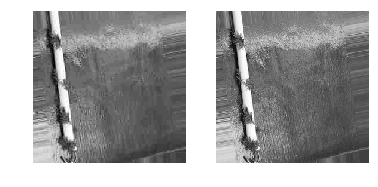

In [12]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [11]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/30
3750/3750 [==============================] - 803s 214ms/step - loss: 0.0077 - val_loss: 0.0121
Epoch 2/30
3750/3750 [==============================] - 795s 212ms/step - loss: 0.0074 - val_loss: 0.0120
Epoch 3/30
3750/3750 [==============================] - 795s 212ms/step - loss: 0.0073 - val_loss: 0.0119
Epoch 4/30
3750/3750 [==============================] - 794s 212ms/step - loss: 0.0072 - val_loss: 0.0119
Epoch 5/30
3750/3750 [==============================] - 792s 211ms/step - loss: 0.0072 - val_loss: 0.0118
Epoch 6/30
3750/3750 [==============================] - 793s 211ms/step - loss: 0.0072 - val_loss: 0.0119
Epoch 7/30
3750/3750 [==============================] - 793s 211ms/step - loss: 0.0072 - val_loss: 0.0120
Epoch 8/30
3750/3750 [==============================] - 793s 212ms/step - loss: 0.0071 - val_loss: 0.0118
Epoch 9/30
3750/3750 [==============================] - 793s 211ms/step - loss: 0.0071 - val_loss: 0.0118
Epoch 10/30
3750/3750 [=======================

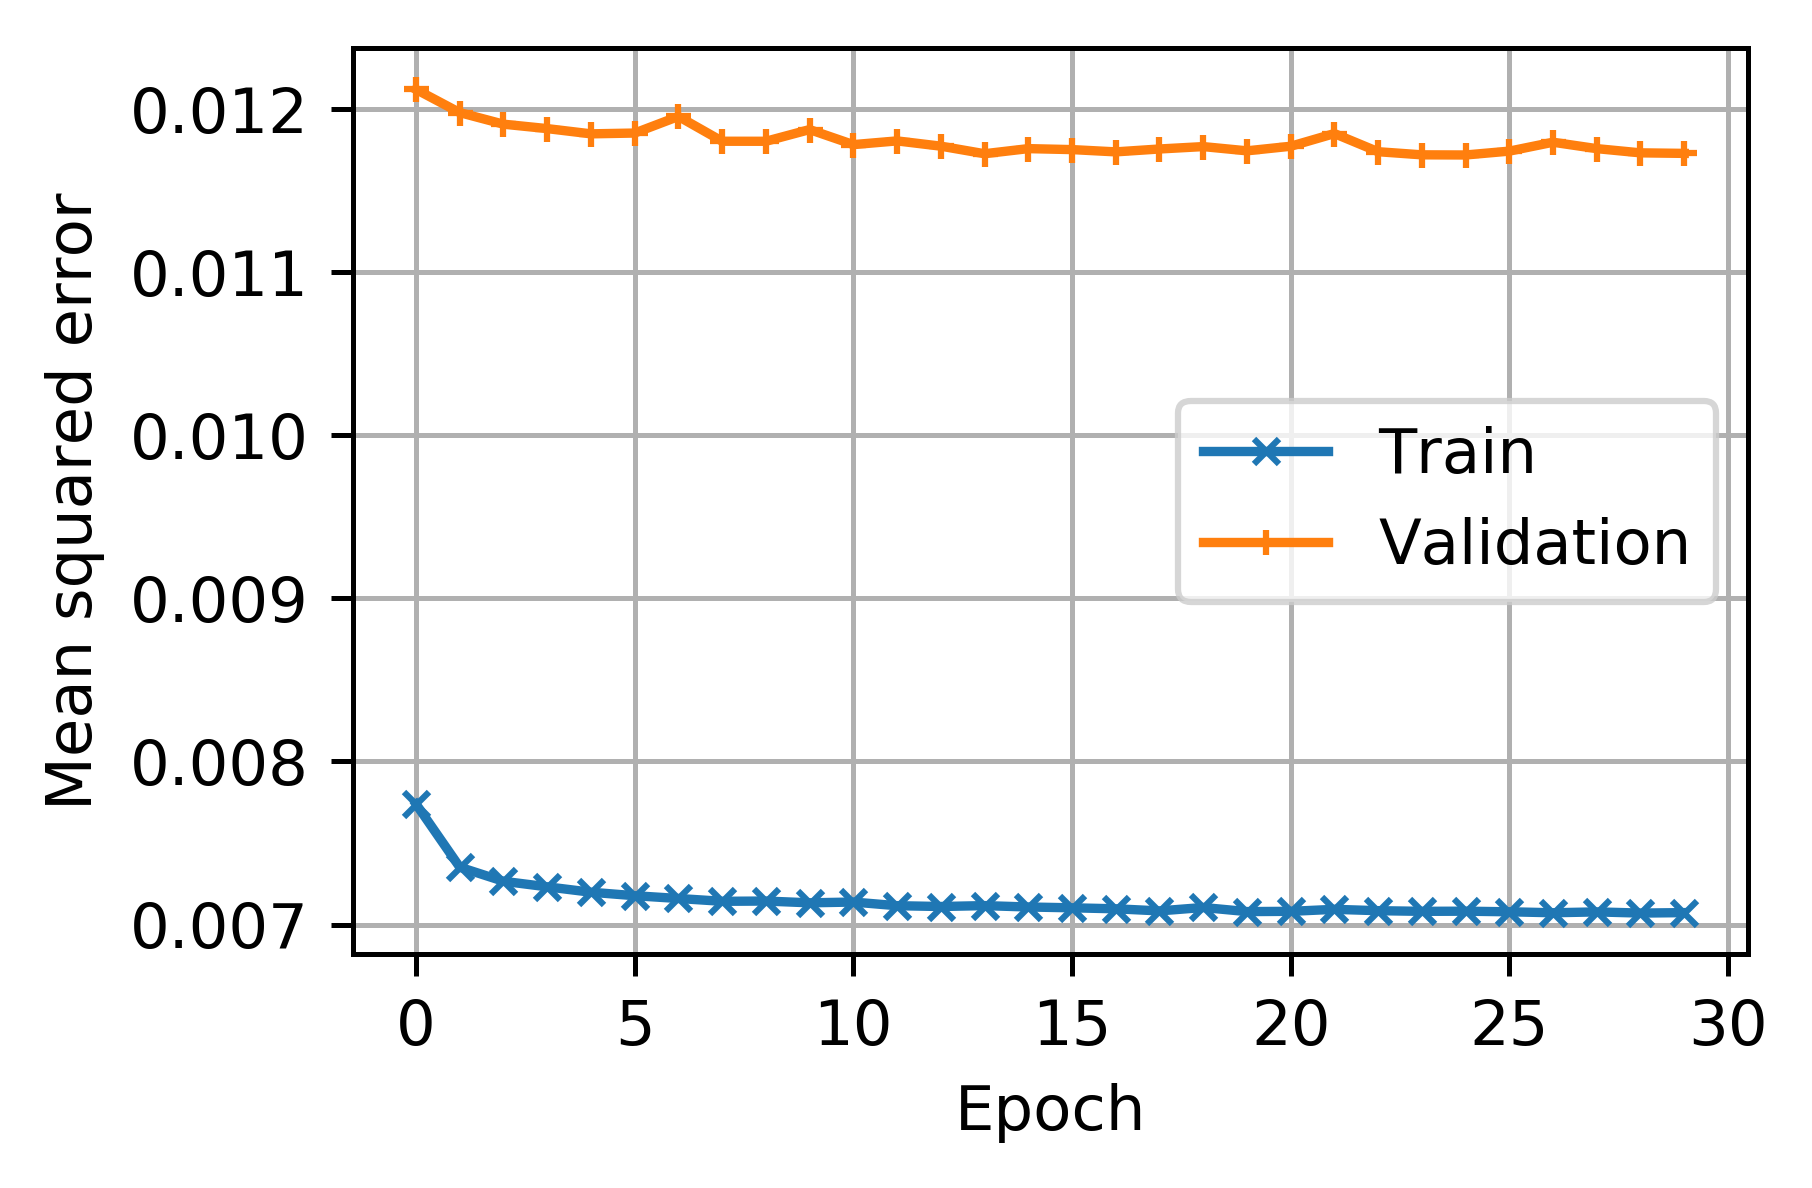

In [12]:
#Saving training history
np.save("../Data/loss_residual_wnet_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_wnet_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [13]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_wnet_dd_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='dd')
model.compile(loss = "mse",optimizer=opt)

0 d
Append DCT layer
Append U-net block
DCT layer again. Don't append iDCT layer.
1 d
Append U-net block
Append iDCT layer


(8, 256, 256, 1)
-1.0 0.9921875
-1.0 0.9921875


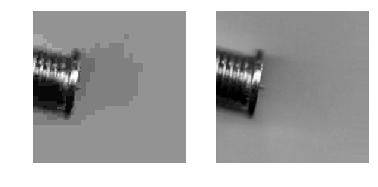

In [14]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [15]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/30
3750/3750 [==============================] - 802s 214ms/step - loss: 0.0093 - val_loss: 0.0138
Epoch 2/30
3750/3750 [==============================] - 799s 213ms/step - loss: 0.0088 - val_loss: 0.0136
Epoch 3/30
3750/3750 [==============================] - 798s 213ms/step - loss: 0.0086 - val_loss: 0.0135
Epoch 4/30
3750/3750 [==============================] - 798s 213ms/step - loss: 0.0086 - val_loss: 0.0135
Epoch 5/30
3750/3750 [==============================] - 798s 213ms/step - loss: 0.0085 - val_loss: 0.0134
Epoch 6/30
3750/3750 [==============================] - 798s 213ms/step - loss: 0.0085 - val_loss: 0.0134
Epoch 7/30
3750/3750 [==============================] - 798s 213ms/step - loss: 0.0085 - val_loss: 0.0133
Epoch 8/30
3750/3750 [==============================] - 798s 213ms/step - loss: 0.0085 - val_loss: 0.0133
Epoch 9/30
3750/3750 [==============================] - 798s 213ms/step - loss: 0.0085 - val_loss: 0.0133
Epoch 10/30
3750/3750 [=======================

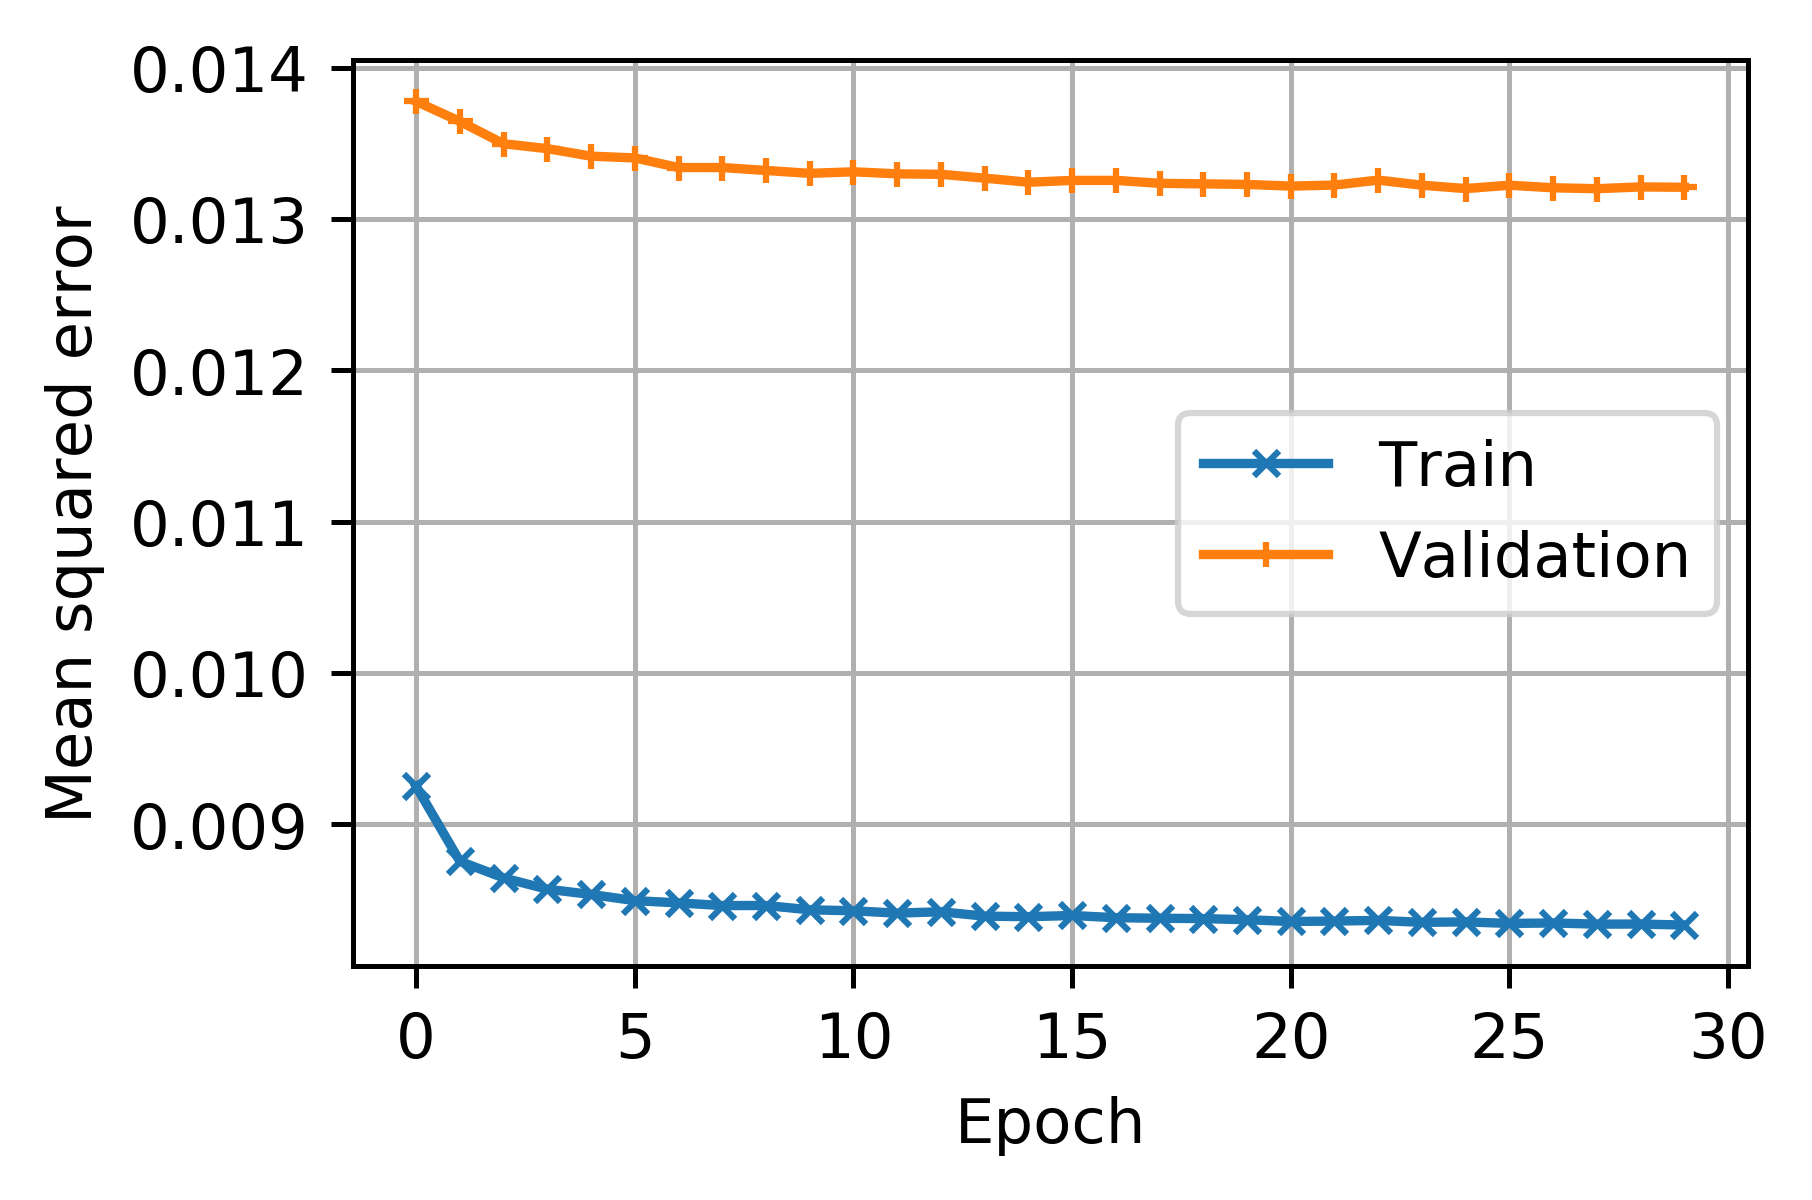

In [16]:
#Saving training history
np.save("../Data/loss_residual_wnet_dd_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_wnet_dd_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [13]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_wnet_ii_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='ii')
model.compile(loss = "mse",optimizer=opt)

0 i
Append U-net block
1 i
Append U-net block


(8, 256, 256, 1)
-1.0 0.9921875
-1.0 0.9921875


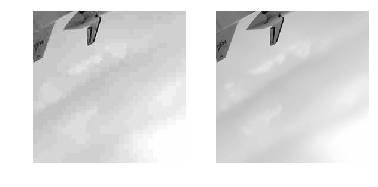

In [14]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [15]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/30
3750/3750 [==============================] - 718s 192ms/step - loss: 0.0032 - val_loss: 0.0061
Epoch 2/30
3750/3750 [==============================] - 710s 189ms/step - loss: 0.0030 - val_loss: 0.0060
Epoch 3/30
3750/3750 [==============================] - 711s 190ms/step - loss: 0.0029 - val_loss: 0.0059
Epoch 4/30
3750/3750 [==============================] - 711s 190ms/step - loss: 0.0029 - val_loss: 0.0059
Epoch 5/30
3750/3750 [==============================] - 711s 190ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 6/30
3750/3750 [==============================] - 711s 189ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 7/30
3750/3750 [==============================] - 711s 190ms/step - loss: 0.0029 - val_loss: 0.0059
Epoch 8/30
3750/3750 [==============================] - 711s 189ms/step - loss: 0.0029 - val_loss: 0.0059
Epoch 9/30
3750/3750 [==============================] - 710s 189ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 10/30
3750/3750 [=======================

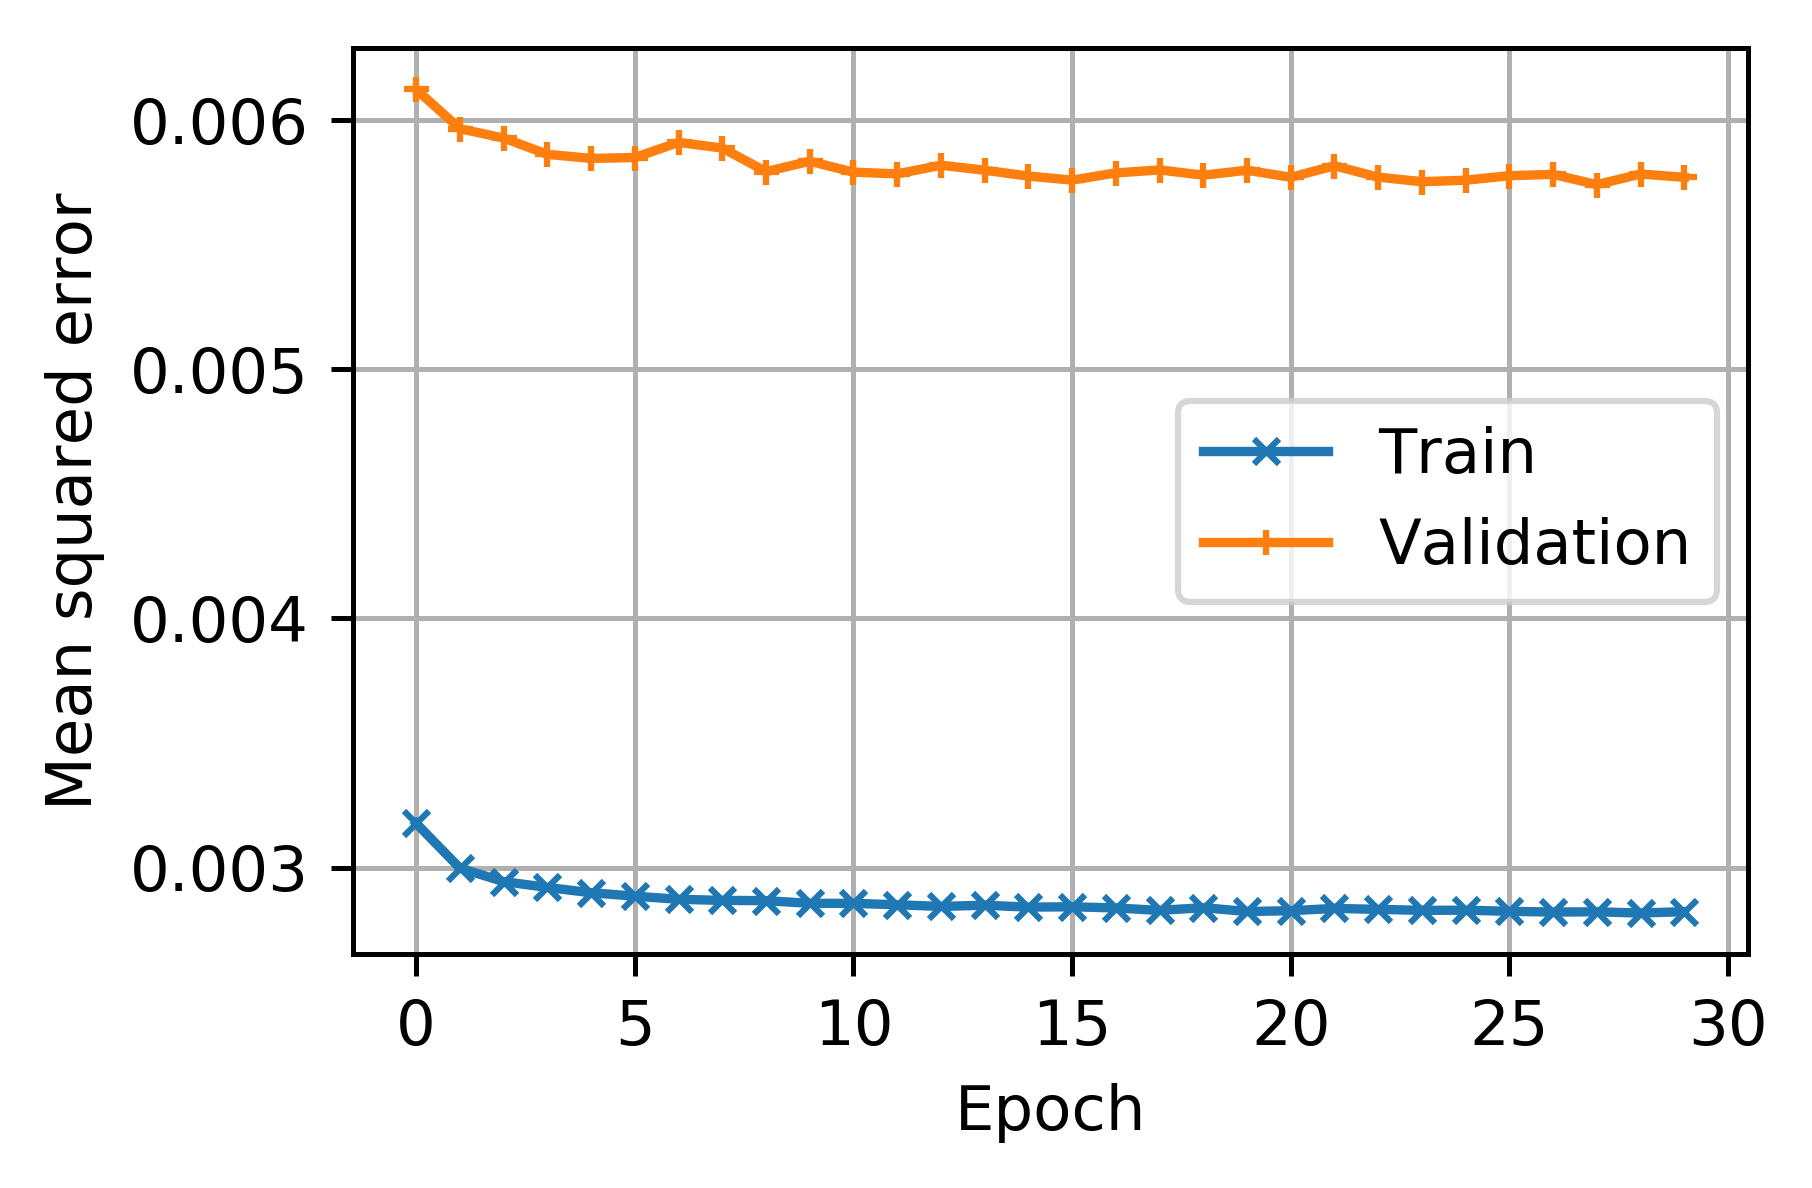

In [16]:
#Saving training history
np.save("../Data/loss_residual_wnet_ii_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_wnet_ii_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [17]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_unet_d_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='d')
model.compile(loss = "mse",optimizer=opt)

0 d
Append DCT layer
Append U-net block
Append iDCT layer


(8, 256, 256, 1)
-1.0 0.9921875
-1.0 0.9921875


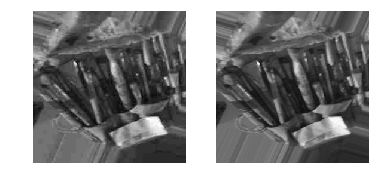

In [18]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/30
 308/3750 [=>............................] - ETA: 6:38 - loss: 0.0043

In [ ]:
#Saving training history
np.save("../Data/loss_residual_unet_d_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_unet_d_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [ ]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_unet_i_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='i')
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_residual_unet_i_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_unet_i_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [2]:
from scipy.fftpack import dct as DCT, idct as IDCT

def py_dct2d(im):
    return DCT(DCT(im,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')
def py_idct2d(mat):
    return IDCT(IDCT(mat,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')

def dct_in_blocks(im, block_size = 8):

    rows, cols = im.shape[0], im.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = im[i:i+block_size, j:j+block_size]
            dct_matrix[i:i+block_size,j:j+block_size] = py_dct2d(block)

    return dct_matrix

def tf_dct_in_blocks(im, block_size = 8):

    rows, cols = im.shape[0], im.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = im[i:i+block_size, j:j+block_size]
            dct_matrix[i:i+block_size,j:j+block_size] = dct2d(block)

    return dct_matrix

def idct_in_blocks(dct_mat, block_size = 8):

    rows, cols = dct_mat.shape[0], dct_mat.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    im_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = dct_mat[i:i+block_size, j:j+block_size]
            im_matrix[i:i+block_size,j:j+block_size] = py_idct2d(block)

    return im_matrix


In [3]:
from keras import backend as K
def tf_dct2d(im):
    return K.tf.transpose(K.tf.spectral.dct(K.tf.transpose(K.tf.spectral.dct(im,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))
    
    
def tf_idct2d(mat):
    return K.tf.transpose(K.tf.spectral.idct(K.tf.transpose(K.tf.spectral.idct(mat,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))


# Modified from:
# https://stackoverflow.com/questions/44047753/reconstructing-an-image-after-using-extract-image-patches
def extract_patches(x):
    return K.tf.extract_image_patches(
        x,
        (1, 8, 8, 1),
        (1, 8, 8, 1),
        (1, 1, 1, 1),
        padding="SAME"
    )


def extract_patches_inverse(x, y):
    _x = K.tf.zeros_like(x)
    _y = extract_patches(_x)
    grad = K.tf.gradients(_y, _x)[0]
    # Divide by grad, to "average" together the overlapping patches
    # otherwise they would simply sum up
    return K.tf.gradients(_y, _x, grad_ys=y)[0] / grad


In [3]:
# Testing stuff
length = 3

tens = np.zeros((length, 256,256,1), dtype=np.float32)
for ii in range(length):
    im1 = Image.open(train_images[ii*150])
    im1_array = np.array(im1)
    
    tens[ii,:,:,0] = im1_array
    
patches = extract_patches(tens)
dct_patches = tf_dct2d(patches)
tf_dct_image = extract_patches_inverse(tens, dct_patches)

dct_patches_2 = extract_patches(tf_dct_image)
img_patches = tf_idct2d(dct_patches_2)
tf_image = extract_patches_inverse(tens,img_patches)

np_tf_dct_image = tf_eval(tf_dct_image)
np_tf_image = tf_eval(tf_image)

for ii in range(length):
    plt.figure(figsize=(18,9))
    plt.subplot(length,3,3*ii+1)
    plt.imshow(tens[ii,:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Original Image")
    plt.subplot(length,3,3*ii+2)
    plt.imshow(np_tf_dct_image[ii,:,:,0],cmap = "gray",vmin=0,vmax=1)
    plt.axis("off")
    plt.title("TF DCT")
    plt.subplot(length,3,3*ii+3)
    plt.imshow(np_tf_image[ii,:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("TF IDCT")
plt.show()

NameError: name 'extract_patches' is not defined

In [6]:
# Testing stuff
length = 3

tens = np.zeros((length, 256,256,1), dtype=np.float32)
for ii in range(length):
    im1 = Image.open(train_images[ii*150])
    im1_array = np.array(im1)
    
    tens[ii,:,:,0] = im1_array

py_dct_img = py_dct2d(im1_array)
tf_dct_img = K.tf.transpose(K.tf.spectral.dct(K.tf.transpose(K.tf.spectral.dct(im1_array,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))

py_img = py_idct2d(py_dct_img)
tf_img = K.tf.transpose(K.tf.spectral.idct(K.tf.transpose(K.tf.spectral.idct(tf_dct_img,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))

plt.figure(figsize=(18,9))
plt.subplot(length,3,1)
plt.imshow(tf_eval(tf_dct_img),cmap = "gray",vmin=0,vmax=1)
plt.axis("off")
plt.title("TF DCT")
plt.subplot(length,3,2)
plt.imshow(py_dct_img,cmap = "gray",vmin=0,vmax=1)
plt.axis("off")
plt.title("PY DCT")
plt.subplot(length,3,4)
plt.imshow(tf_eval(tf_img),cmap = "gray")
plt.axis("off")
plt.title("TF IDCT")
plt.subplot(length,3,5)
plt.imshow(py_img,cmap = "gray")
plt.axis("off")
plt.title("PY IDCT")
plt.show()

mse = ((py_dct_img - tf_eval(tf_dct_img))**2).mean(axis=None)

print("TF DCT: ", np.mean(tf_eval(tf_dct_img)), np.min(tf_eval(tf_dct_img)), np.max(tf_eval(tf_dct_img)))
print("PY DCT: ", np.mean(py_dct_img), np.min(py_dct_img), np.max(py_dct_img))
print("TF IDCT: ", np.mean(tf_eval(tf_img)), np.min(tf_eval(tf_img)), np.max(tf_eval(tf_img)))
print("PY IDCT: ", np.mean(py_img), np.min(py_img), np.max(py_img))
#print(py_dct_img == tf_eval(tf_dct_img))
print(mse)

# py_dct_image = tens.copy()
# tf_dct_image = tens.copy()
# for ii in range(length):
#     py_dct_image[ii,:,:,0] = py_dct2d(tens[ii,:,:,0])
#     tf_dct_image[ii,:,:,0] = tf_dct2d(tens[ii,:,:,0])

# # py_dct_image = tens.copy()
# # tf_dct_image = tens.copy()
# # for ii in range(length):
# #     py_dct_image[ii,:,:,0] = dct_in_blocks(tens[ii,:,:,0])
# #     tf_dct_image = tf_dct_in_blocks(tens[ii,:,:,0])


# # patches = extract_patches(tens)
# # dct_patches = dct2d(patches)
# # tf_dct_image = extract_patches_inverse(tens, dct_patches)

# print(tf_dct_image.eval)
# test = tf_eval(tf_dct_image)
# # Display the images
# plt.figure(figsize=(18,9))
# for ii in range(length):
#     plt.subplot(length,3,3*ii+1)
#     plt.imshow(tens[ii,:,:,0],cmap = "gray")
#     plt.axis("off")
#     plt.title("Uncompressed")
#     plt.subplot(length,3,3*ii+2)
#     plt.imshow(py_dct_image[ii,:,:,0],cmap = "gray",vmin=0,vmax=1)
#     plt.axis("off")
#     plt.title("Python DCT")
#     plt.subplot(length,3,3*ii+3)
#     plt.imshow(test[ii,:,:,0],cmap = "gray",vmin=0,vmax=1)
#     plt.axis("off")
#     plt.title("TF DCT")
# plt.show()

NameError: name 'py_dct2d' is not defined